In [1]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Input, Flatten
import nltk
from nltk.tokenize import word_tokenize
import re
import html
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras import regularizers
from keras import optimizers
from keras.callbacks import LearningRateScheduler
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset



c:\Users\ADHISH S\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf

# Check if TensorFlow can see any GPUs
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) == 0:
    print("No GPU devices found. TensorFlow will run on CPU.")
else:
    print("GPU devices found. TensorFlow will run on GPU(s).")

# Optional: You can print information about each GPU device
for gpu_device in gpu_devices:
    print(f"GPU device name: {gpu_device.name}")
    print(f"GPU device type: {gpu_device.device_type}")


GPU devices found. TensorFlow will run on GPU(s).
GPU device name: /physical_device:GPU:0
GPU device type: GPU


In [3]:
# Loading dataset
train_data = pd.read_csv("mal_train.csv")
test_data = pd.read_csv("mal_test.csv")
validation_data = pd.read_csv("mal_validation.csv")

In [4]:
#Cleaning Malayalam Text

special_characters_to_remove = r'[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~\\]'


def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ').replace('\u200d', '').replace('\xa0', ' ').replace(
        '\u200c', '').replace('“', ' ').replace('”', ' ').replace('"', ' ').replace('\u200b', '')
    x = re.sub(r'\([^)]*\)', '', x)  # Remove text within parentheses
    x = re.sub('<[^<]+?>', '', x)  # Remove HTML tags
    x = re.sub(r'\d+(\.\d+)?', 'NUM ', x)  # Replace numbers with 'NUM'
    x = re.sub(special_characters_to_remove, ' ', x)  # Remove specified special characters
    x = re.sub(r'\s+', ' ', x)  # Remove extra spaces
    return x.strip()  # Strip leading/trailing spaces

In [5]:
#Headline Tockenisation
def tokenize_malayalam_text(data):
    tokenized_headlines = []
    for headline in data["News_Headline"]:
        # Preprocess the headline
        cleaned_headline = fixup(headline)
        
        # Tokenize the cleaned headline into words
        words = word_tokenize(cleaned_headline, language="malayalam")
        tokenized_headlines.append(words)
    return tokenized_headlines

In [6]:
# Preprocess and tokenize the training, test, and validation datasets
train_tokenized = tokenize_malayalam_text(train_data)
test_tokenized = tokenize_malayalam_text(test_data)
validation_tokenized = tokenize_malayalam_text(validation_data)

In [7]:
print(train_tokenized)

[['ആരാട', 'ഇങ്ങനെ', 'ചെയ്തത്'], ['ആനക്കൊമ്പ്', 'കേസ്', 'മോഹൻലാൽ', 'നേരിട്ടു', 'ഹാജരാകണം'], ['ഈ', 'പരാതിയുടെ', 'മറുപടിക്കായി', 'കാത്തിരിക്കുക', '…'], ['ഇതാണോ', 'കമ്യൂണിസം'], ['ഉമ്മന്', 'ചാണ്ടിയുടെ', 'സ്തൂപം', 'തകര്ത്തു', 'CITU', 'നേതാവ്', 'അറസ്റ്റില്'], ['NUM', 'ലക്ഷം', 'വേറെയും', 'മുഖ്യമന്ത്രിയുടെ', 'മകൾക്കെതിരെ', 'കൂടുതൽ', 'സാമ്പത്തിക', 'ആരോപണങ്ങളുമായി', 'മാത്യു', 'കുഴൽനാടൻ'], ['കമ്യുണിസ്റ്റ്', 'കാർക്കും', 'ഇതാണിപ്പം', 'അഭിപ്രായം', '…'], ['നേപ്പാൾ', 'തങ്ങളുടെ', 'കറൻസിയിൽ', 'ഗൗതമ', 'ബുദ്ധന്റെ', 'ചിത്രം', 'ചേർത്തു'], ['കെ', 'ഫോണിൽ', 'ഖജനാവിന്', 'നഷ്ടം', 'NUM', 'കോടിയിലേറെയെന്ന്', 'സിഎജി', 'കൺസോർഷ്യം', 'കരാർ', 'നൽകിയത്', 'വ്യവസ്ഥകൾ', 'മറികടന്ന്'], ['ഞാൻ', 'വിമതനല്ല', 'സിപിഎം', 'തന്നെ', 'നിഷേധിച്ചല്ലോ', 'പുതുപ്പള്ളി', 'വിമത', 'വിവാദത്തിൽ', 'പ്രതികരിച്ച്', 'നിബു', 'ജോൺ'], ['വിഡിയോ', 'കോളിൽ', 'സ്ക്രീൻ', 'ഷെയറിങ്ങും', 'വാട്സാപ്പിന്റെ', 'പുതിയ', 'സംവിധാനം', 'സൈബർ', 'തട്ടിപ്പിനു', 'കാരണമാകാം'], ['ഇതാരാണോ', 'ആവോ', '…'], ['രാജ്യ', 'ദ്രോഹികൾ', '…'], ['ഇന്ത്യയിൽ', 'വീണ്ടും', 'ലോക്ക്ഡൗൺ', 'പ്രഖ്യാപ

In [8]:

# Example: Print tokenized headline from the training dataset
print("Original Headline:", train_data["News_Headline"].iloc[45])
print("Preprocessed and Tokenized Headline:", train_tokenized[45])


Original Headline: തീവ്രവാദി ആക്രമണം; പാകിസ്ഥാനിൽ 11 പേർ കൊല്ലപ്പെട്ടു
Preprocessed and Tokenized Headline: ['തീവ്രവാദി', 'ആക്രമണം', 'പാകിസ്ഥാനിൽ', 'NUM', 'പേർ', 'കൊല്ലപ്പെട്ടു']


In [9]:

# Extracting word vectors using Word2Vec
def extract_word_vectors(tokenized_data, vector_size=300, window=5, min_count=1, sg=0):
    model = Word2Vec(sentences=tokenized_data, vector_size=vector_size, window=window, min_count=min_count, sg=sg)
    word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
    return word_vectors


In [10]:
# Extracting word vectors for the tokenized training, test, and validation datasets
train_word_vectors = extract_word_vectors(train_tokenized)
test_word_vectors = extract_word_vectors(test_tokenized)
validation_word_vectors = extract_word_vectors(validation_tokenized)



In [11]:
# Constants
MAX_SEQUENCE_LENGTH = 100 
EMBEDDING_DIM = 300 
num_classes = 2  # Number of classes (fake and not fake)
num_filters = 64 
weight_decay = 1e-4
maxlen = 50
vocab_size=len(train_word_vectors)
initial_lr = 1e-3 #learning rate

In [12]:
from keras.preprocessing.text import Tokenizer

# Creating a tokenizer and fitting it on the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tokenized)

# Converting the tokenized text to sequences of integers
X_train = tokenizer.texts_to_sequences(train_tokenized)
X_val = tokenizer.texts_to_sequences(validation_tokenized)
X_test = tokenizer.texts_to_sequences(test_tokenized)

# Pad sequences to have the same length
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)


In [13]:


traind = pd.read_csv('mal_train.csv')
testd = pd.read_csv('mal_test.csv')
valdd=pd.read_csv('mal_validation.csv')


train_labels = traind['Class']

test_labels  = testd['Class']

validation_lables =valdd['Class']

CREATING LSTM MODEL

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [15]:
# Encoding labels using LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
val_labels_encoded = label_encoder.transform(validation_lables)

In [16]:
# Defining lr_schedule function
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 0.1
    return lr

In [18]:

# Creating a custom LearningRateScheduler callback
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        # Call the lr_schedule function to get the new learning rate
        new_lr = lr_schedule(epoch)
        # Set the new learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
        print(f'\nEpoch {epoch+1} Learning Rate: {new_lr}')

# Creating the LSTM model
model = Sequential()

vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if word in train_word_vectors:
        embedding_matrix[i] = train_word_vectors[word]

embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix], trainable=False)
model.add(embedding_layer)

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [19]:

# Initializing the learning rate using lr_schedule(0)
optimizer = Adam(learning_rate=lr_schedule(0))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [20]:
# Training the model
batch_size = 32
epochs = 10

# Creating an instance of the custom learning rate scheduler callback
lr_scheduler = CustomLearningRateScheduler()

history = model.fit(X_train, train_labels_encoded,
                    validation_data=(X_val, val_labels_encoded),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[lr_scheduler])


Epoch 1/10

Epoch 1 Learning Rate: 0.001
41/41 - 5s - loss: 0.6942 - accuracy: 0.4560 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10

Epoch 2 Learning Rate: 0.001
41/41 - 1s - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/10

Epoch 3 Learning Rate: 0.001
41/41 - 1s - loss: 0.6924 - accuracy: 0.5170 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 4/10

Epoch 4 Learning Rate: 0.001
41/41 - 1s - loss: 0.6763 - accuracy: 0.5742 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 5/10

Epoch 5 Learning Rate: 0.001
41/41 - 1s - loss: 0.6337 - accuracy: 0.6020 - val_loss: 0.6805 - val_accuracy: 0.2500
Epoch 6/10

Epoch 6 Learning Rate: 0.001
41/41 - 1s - loss: 0.6297 - accuracy: 0.6005 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 7/10

Epoch 7 Learning Rate: 0.0001
41/41 - 1s - loss: 0.6216 - accuracy: 0.5912 - val_loss: 0.6974 - val_accuracy: 0.5000
Epoch 8/10

Epoch 8 Learning Rate: 0.0001
41/41 - 1s - loss: 0.6215 - accuracy: 0.5958 - val_loss: 0.69

In [17]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, test_labels_encoded, verbose=2)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

18/18 - 0s - loss: 0.6101 - accuracy: 0.6286
Test Accuracy: 62.86%


CREATING IMAGE MODEL

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from PIL import Image  
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, BatchNormalization, Input, Concatenate
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import os
import PIL

In [22]:
def load_and_preprocess_images(image_paths, max_sequence_length):
    base_model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

    images = []
    for path in image_paths:
        try:
            img = Image.open(path)  
            img = img.convert("RGB")  # Convert to RGB format
            img = img.resize((224, 224))  # Resize the image to VGG-16 input size
            img = image.img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)
            features = model.predict(img)
            # Flatten the features and ensure they have the same length as max_sequence_length
            flattened_features = features.flatten()[:max_sequence_length]
            if len(flattened_features) < max_sequence_length:
                # If features are shorter than max_sequence_length, pad with zeros
                pad_length = max_sequence_length - len(flattened_features)
                flattened_features = np.pad(flattened_features, (0, pad_length), 'constant')
            images.append(flattened_features)
        except (PIL.UnidentifiedImageError, OSError) as e:
            print(f"Skipping image {path} due to error: {str(e)}")

    return np.array(images)

In [26]:
# Loading image data paths and extract features
image_dir = "output_images"
image_paths_train = [os.path.join(image_dir, filename) for filename in train_data['image_name']]
image_paths_val = [os.path.join(image_dir, filename) for filename in validation_data['image_name']]
image_paths_test = [os.path.join(image_dir, filename) for filename in test_data['image_name']]

# To Ensure that image features have the same length as text sequences
train_image_features = load_and_preprocess_images(image_paths_train, MAX_SEQUENCE_LENGTH)
val_image_features = load_and_preprocess_images(image_paths_val, MAX_SEQUENCE_LENGTH)
test_image_features = load_and_preprocess_images(image_paths_test, MAX_SEQUENCE_LENGTH)


# Ensure the dimensions of text and image features match by checking the number of samples
if len(X_train) != len(train_image_features):
    raise ValueError("Number of samples in text and image features must match.")

In [27]:
# Create an image-based model
image_model = Sequential()
image_model.add(Dense(256, activation='relu', input_shape=(train_image_features.shape[1],)))
image_model.add(Dropout(0.5))
image_model.add(Dense(64, activation='relu'))
image_model.add(Dense(2, activation='softmax'))  # 2 classes (real and fake)

# Compile the image model
image_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])


In [28]:
image_model.fit(train_image_features, train_labels_encoded, epochs=10, batch_size=32,
                validation_data=(val_image_features, val_labels_encoded))


Epoch 1/10
41/41 [==============================] - 0s 4ms/step - loss: 1.9534 - accuracy: 0.5726 - val_loss: 0.6295 - val_accuracy: 0.7500
Epoch 2/10
41/41 [==============================] - 0s 2ms/step - loss: 1.1927 - accuracy: 0.6252 - val_loss: 0.6955 - val_accuracy: 0.7500
Epoch 3/10
41/41 [==============================] - 0s 3ms/step - loss: 0.9374 - accuracy: 0.6376 - val_loss: 0.8109 - val_accuracy: 0.7500
Epoch 4/10
41/41 [==============================] - 0s 3ms/step - loss: 0.8384 - accuracy: 0.6453 - val_loss: 0.8095 - val_accuracy: 0.5000
Epoch 5/10
41/41 [==============================] - 0s 3ms/step - loss: 0.7619 - accuracy: 0.6399 - val_loss: 0.6615 - val_accuracy: 0.7500
Epoch 6/10
41/41 [==============================] - 0s 4ms/step - loss: 0.6685 - accuracy: 0.6839 - val_loss: 0.6312 - val_accuracy: 0.5000
Epoch 7/10
41/41 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6754 - val_loss: 0.6613 - val_accuracy: 0.7500
Epoch 8/10
41/41 [==

In [29]:
# Assuming 'test_labels_encoded' are the labels for test images
test_loss, test_accuracy = image_model.evaluate(test_image_features, test_labels_encoded)
print(f'Image Model Test Accuracy: {test_accuracy * 100:.2f}%')


18/18 [==============================] - 0s 1ms/step - loss: 0.7085 - accuracy: 0.6395
Image Model Test Accuracy: 63.95%


FUSION MODEL

In [77]:
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model

# Creating input layers for text and image models
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
image_input = Input(shape=(train_image_features.shape[1],))

# Get the output from the text model
text_output = model(text_input)  

# Get the output from the image model
image_output = image_model(image_input)  

# Concatenate the outputs from both models
concatenated = Concatenate()([text_output, image_output])

# Add a fully connected layer for fusion
fusion_output = Dense(64, activation='relu')(concatenated)

# Adding the final output layer with softmax activation
output = Dense(num_classes, activation='softmax')(fusion_output)

# Creating the fusion model
fusion_model = Model(inputs=[text_input, image_input], outputs=output)

# Compiling the fusion model
fusion_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])


In [78]:

history = fusion_model.fit([X_train, train_image_features], train_labels_encoded,
                           validation_data=([X_val, val_image_features], val_labels_encoded),
                           epochs=10, batch_size=32, verbose=2)


Epoch 1/10
41/41 - 5s - loss: 0.6509 - accuracy: 0.6051 - val_loss: 0.5889 - val_accuracy: 1.0000
Epoch 2/10
41/41 - 1s - loss: 0.5566 - accuracy: 0.7674 - val_loss: 0.5829 - val_accuracy: 0.7500
Epoch 3/10
41/41 - 1s - loss: 0.5060 - accuracy: 0.7713 - val_loss: 0.6524 - val_accuracy: 0.7500
Epoch 4/10
41/41 - 1s - loss: 0.4897 - accuracy: 0.7743 - val_loss: 0.6663 - val_accuracy: 0.7500
Epoch 5/10
41/41 - 1s - loss: 0.4400 - accuracy: 0.8107 - val_loss: 0.4970 - val_accuracy: 0.7500
Epoch 6/10
41/41 - 1s - loss: 0.4458 - accuracy: 0.8068 - val_loss: 0.3493 - val_accuracy: 1.0000
Epoch 7/10
41/41 - 1s - loss: 0.4091 - accuracy: 0.8284 - val_loss: 0.3606 - val_accuracy: 1.0000
Epoch 8/10
41/41 - 1s - loss: 0.4225 - accuracy: 0.8261 - val_loss: 0.4984 - val_accuracy: 0.7500
Epoch 9/10
41/41 - 1s - loss: 0.4120 - accuracy: 0.8261 - val_loss: 0.2634 - val_accuracy: 1.0000
Epoch 10/10
41/41 - 1s - loss: 0.3909 - accuracy: 0.8323 - val_loss: 0.2729 - val_accuracy: 1.0000


In [79]:
test_loss, test_accuracy = fusion_model.evaluate([X_test, test_image_features], test_labels_encoded, verbose=2)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


18/18 - 0s - loss: 0.6502 - accuracy: 0.6975
Test Accuracy: 69.75%


In [80]:
print(fusion_model.summary())


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 2)            2609134     input_6[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 2)            42434       input_7[0][0]                    
____________________________________________________________________________________________

Saving the model

In [81]:
# Saving the fusion model to a file
fusion_model.save("fusion__model.h5")


In [82]:
from tensorflow.keras.models import load_model

loaded_model = load_model("fusion__model.h5")


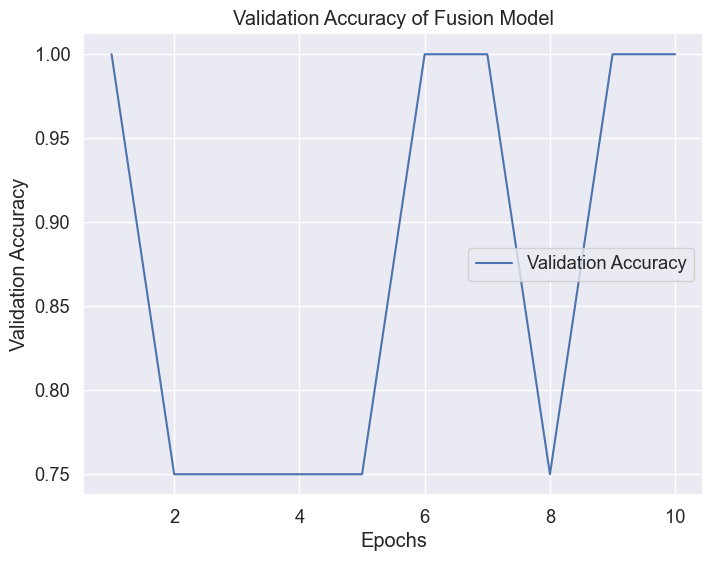

In [83]:
import matplotlib.pyplot as plt

# Extract validation accuracy values from the training history
val_accuracy = history.history['val_accuracy']

# Plot the validation accuracy
epochs = range(1, len(val_accuracy) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Validation Accuracy of Fusion Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


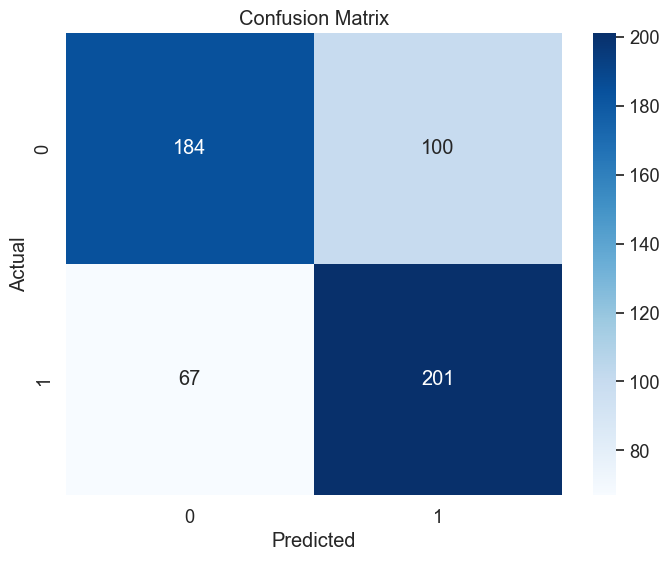

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight

# Assuming you have predictions for the test data from fusion_model
test_predictions = fusion_model.predict([X_test, test_image_features])
# Assuming 'test_labels_encoded' contains the true labels

# Calculate the confusion matrix
confusion_mat = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Prediction from user input

In [98]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model


# Load the pre-trained fusion model
fusion_model = load_model('fusion__model.h5')
#Headline Tockenisation
def tokenize_malayalam_ptext(data):
    tokenized_headlines = []
    cleaned_headline = fixup(data)
    words = word_tokenize(cleaned_headline, language="malayalam")
    tokenized_headlines.append(words)
    return tokenized_headlines

# Define a function to preprocess external text data
def preprocess_text(text_data):
    tokenized_text = tokenize_malayalam_ptext(text_data)
    word_vectors = extract_word_vectors(tokenized_text)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tokenized_text)
    word_vectors = tokenizer.texts_to_sequences(tokenized_text)
    padded_sequences = pad_sequences(word_vectors, maxlen=MAX_SEQUENCE_LENGTH)

    return padded_sequences

# Defining a function to load and preprocess external image data
def preprocess_images(image_paths):
    image_features = load_and_preprocess_images(image_paths, MAX_SEQUENCE_LENGTH)
    return image_features

external_text_data ="കുട്ടികളെ കൊല്ലുന്ന ‘സീരിയൽ കൊലയാളി’യായി ലൂസി; 30 കുട്ടികളെ കൂടി ലക്ഷ്യമിട്ടോ എന്നു സംശയം"
external_image_paths = [r"C:\Users\ADHISH S\Desktop\mini_project\output_images\image1510.png"]


# Preprocessing the external data
external_text_features = preprocess_text(external_text_data)
external_image_features = preprocess_images(external_image_paths)

# Making predictions on the external data
external_predictions = fusion_model.predict([external_text_features, external_image_features])

# Setting a threshold to determine the class label
threshold = 0.5  


external_predicted_labels = (external_predictions[:, 1] >= threshold).astype(int)

# Printing the predicted labels
print("Predicted Labels for External Data:", external_predicted_labels)

if external_predicted_labels == 1:
    print("The given News is True")
elif external_predicted_labels == 0:
    print("The Given News is fake")
else:
    print("Invalid label. Please provide a valid label (0 or 1).")





Predicted Labels for External Data: [1]
The given News is True


In [94]:
print(external_image_features)


[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  12.583228    0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   5.7236023   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          5.856752
   7.561197    0.          0.          0.         37.59648     0.
   0.          0.          0.         41.94517     0.          0.
   0.          0.         23.319763    0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          3.6741457
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          

In [95]:
print(external_text_features)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6
   7  8  9 10]]


In [96]:
print("Shape of external_text_features:", external_text_features.shape)
print("Shape of external_image_features:", external_image_features.shape)


Shape of external_text_features: (1, 100)
Shape of external_image_features: (1, 100)
